In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.collection_of_experiments import CollectionOfExperiments
from helpers.experiment import Experiment
from helpers.plot_helpers import *
from helpers.computational_tools import remesh, gaussian_remesh, select_LatLon, Lk_error, x_coord, y_coord, filter_apply, filter_iteration
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import holoviews as hv
hvplot.output(widget_location='bottom')

# Componentwise check of every array

In [79]:
exp = Experiment('/scratch/pp2681/mom6/regression_tests/testing_offline')

In [80]:
from xgcm import Grid
grid = Grid(exp.mom, coords={
            'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'}
            }
            )

In [3]:
# def compare(online = exp.mom.sh_xx,offline=exp.sh_xx(), zl=0, vmax=None):
#     plt.figure(figsize=(12,3))
#     plt.subplot(1,3,1)
#     online.isel(zl=zl).plot()
#     plt.title('online')
#     plt.subplot(1,3,2)
#     offline.isel(zl=zl).plot()
#     plt.title('offline')
#     plt.title('')
#     plt.subplot(1,3,3)
#     (online-offline).isel(zl=zl).plot(vmax=vmax)
#     plt.title('difference')
#     plt.tight_layout()

In [84]:
# compare()

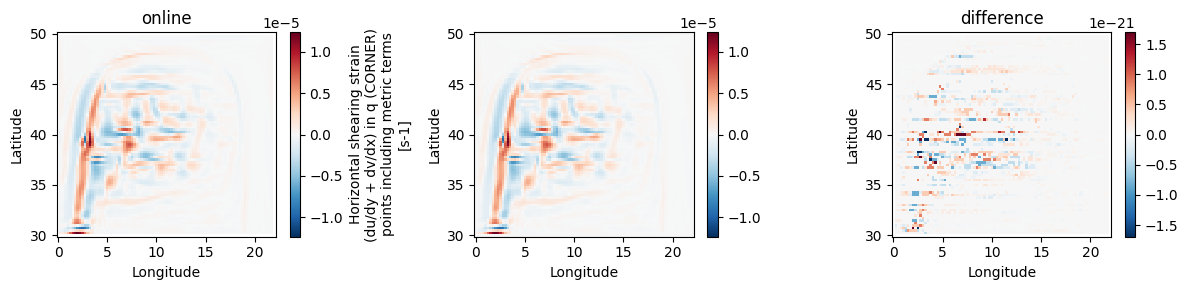

In [47]:
compare(exp.mom.sh_xy, exp.sh_xy(),zl=0)

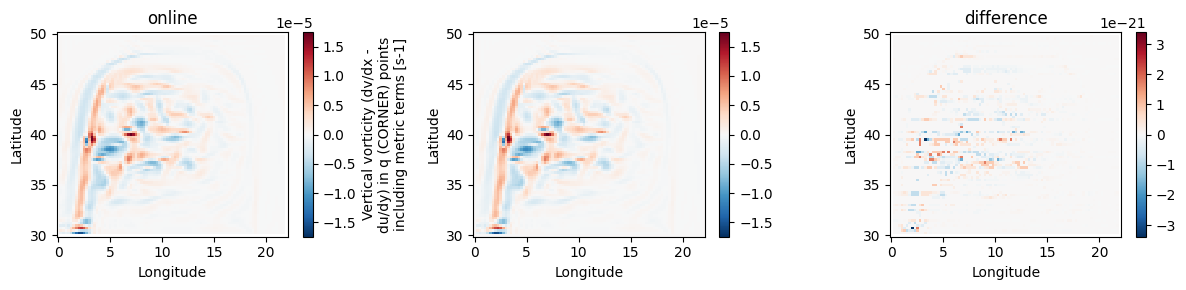

In [48]:
compare(exp.mom.vort_xy, exp.vort_xy(),zl=0)

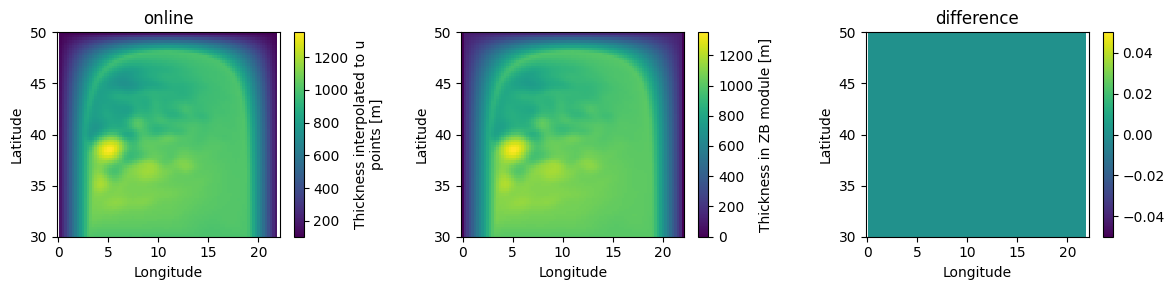

In [72]:
compare(exp.mom.h_u, exp.h_u,zl=0)

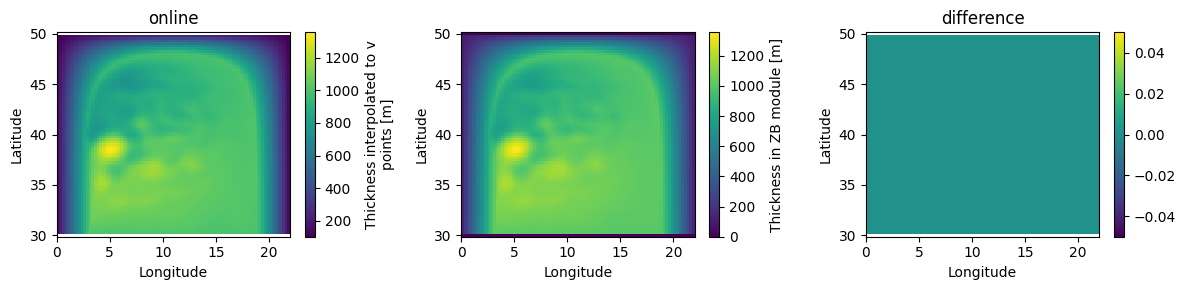

In [50]:
compare(exp.mom.h_v, exp.h_v,zl=0)

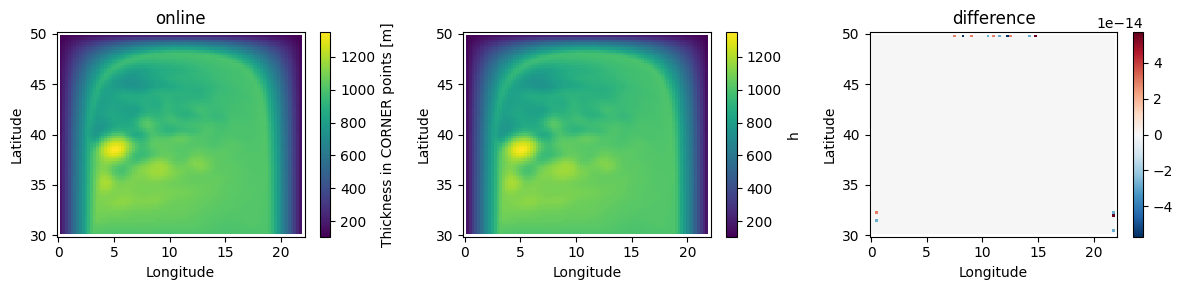

In [51]:
compare(exp.mom.hq, exp.hq,zl=0)

In [52]:
amp = 1.0
sh_xx = exp.mom.sh_xx
vort_xy = exp.mom.vort_xy
sh_xy = exp.mom.sh_xy
h_u = exp.mom.h_u
h_v = exp.mom.h_v
hq = exp.mom.hq

areaBu = exp.param.dxBu * exp.param.dyBu
areaT = exp.param.dxT * exp.param.dyT

sum_sq = 0.5 * (remesh(vort_xy,exp.h)**2+remesh(sh_xy,exp.h)**2+sh_xx**2)
vort_sh = remesh(vort_xy,exp.h) * remesh(sh_xy,exp.h)

k_bc = - amp * areaT
S_11 = k_bc * (- vort_sh + sum_sq)
S_22 = k_bc * (+ vort_sh + sum_sq)
k_bc =  - amp * areaBu
S_12 = k_bc * vort_xy * remesh(sh_xx,vort_xy)

Txx = S_11 * exp.h
Tyy = S_22 * exp.h
Txy = S_12 * exp.mom.hq

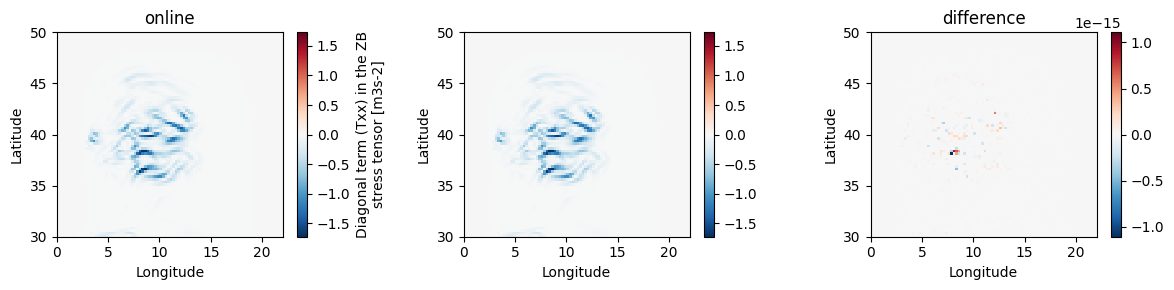

In [59]:
compare(exp.mom.Txx,Txx, zl=1)

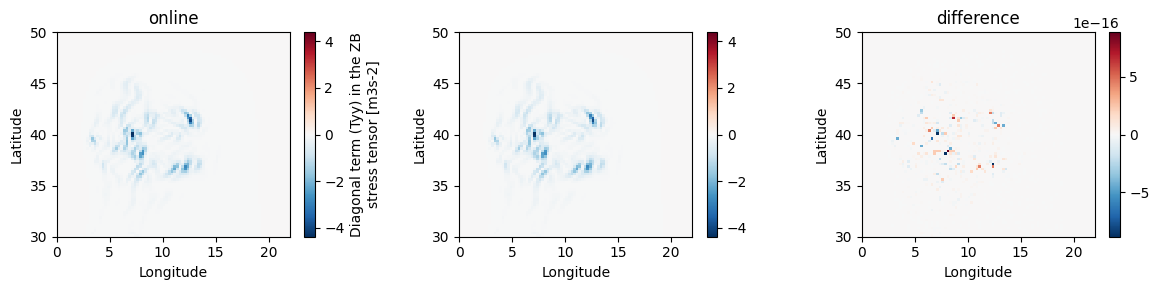

In [60]:
compare(exp.mom.Tyy,Tyy, zl=1)

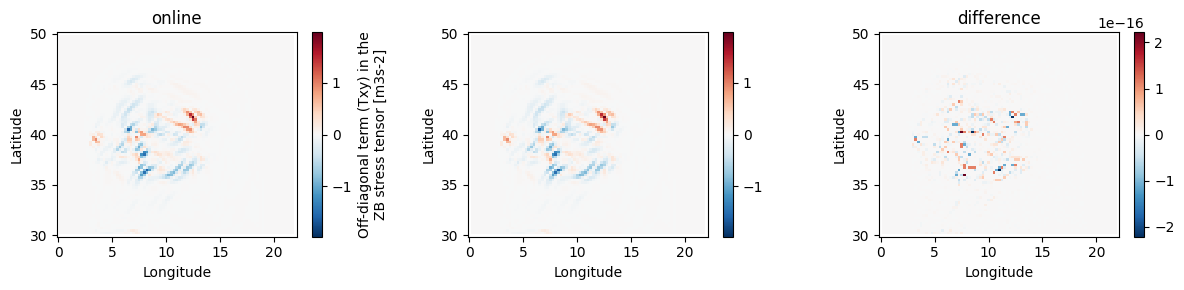

In [61]:
compare(exp.mom.Txy,Txy,zl=1)

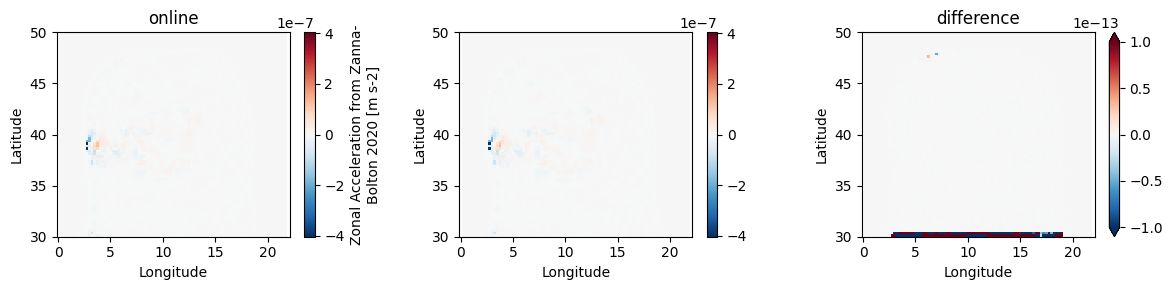

In [62]:
compare(exp.mom.ZB2020u,exp.ZB_offline(ZB_cons=0)[0],zl=1, vmax=1e-13)

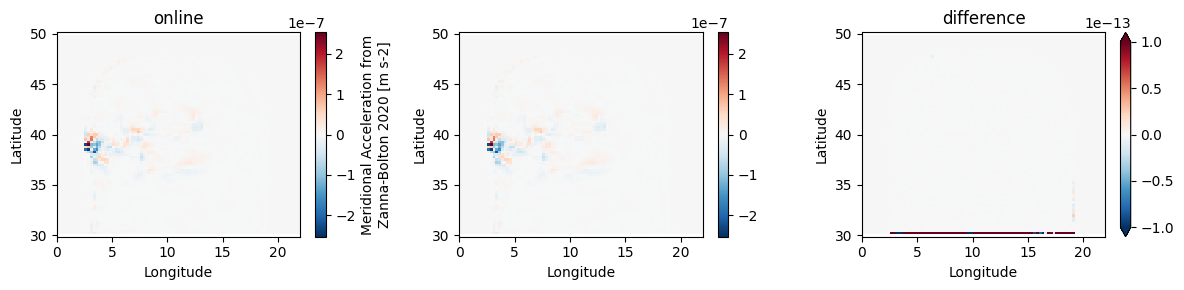

In [65]:
compare(exp.mom.ZB2020v,exp.ZB_offline(ZB_cons=0)[1],zl=1, vmax=1e-13)

# Check boundary condition on NW2 configuration
Note that placing b.c. inside the xgcm is not needed because we implement all B.C. with masks as in MOM6

In [ ]:
folder = '/scratch/pp2681/mom6/regression_tests/profiling-NW2'
param = xr.open_dataset(f'{folder}/ocean_geometry.nc').rename({'lonq': 'xq', 'latq': 'yq', 'lonh': 'xh', 'lath': 'yh'})
static = xr.open_dataset(f'{folder}/static.nc', decode_times=False)
param = xr.merge([param, static])
mom = xr.open_dataset(f'{folder}/mom_00030001.nc', decode_times=False).squeeze()

In [3]:
for key in mom.variables:
    mom[key] = mom[key].fillna(1e+20)

In [4]:
from xgcm import Grid
grid = Grid(mom, coords={
            'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'}
            },
            periodic = 'X'
            )

In [5]:
# Physical B.C.: no-normal flow;
# We apply it by multiplying with wet_u and wet_v
dudx = grid.diff(mom.u * param.wet_u / param.dyCu, 'X') * param.dyT / param.dxT
dvdy = grid.diff(mom.v * param.wet_v / param.dxCv, 'Y') * param.dxT / param.dyT
print(dudx.shape)
print(dvdy.shape)

(15, 280, 120)
(15, 280, 120)


In [6]:
# Physical B.C.: free-slip, i.e. du/dy=0 on the boundary;
# We apply it by multiplying the result by the mask
dudy = grid.diff(mom.u / param.dxCu, 'Y') * param.dxBu / param.dyBu * param.wet_c
dvdx = grid.diff(mom.v / param.dyCv, 'X') * param.dyBu / param.dxBu * param.wet_c

print(dudy.shape)
print(dvdx.shape)

(15, 281, 121)
(15, 281, 121)


In [7]:
sh_xx = dudx-dvdy
sh_xy = dvdx+dudy
vort_xy=dvdx-dudy

In [10]:
# We compare masked fields because outside there may be 1e+20 values
def compare(online, offline, mask, zl=-1, vmax=None):
    plt.figure(figsize=(12,3))
    plt.subplot(1,3,1)
    (online*mask).isel(zl=zl).plot()
    plt.title('online')
    plt.subplot(1,3,2)
    (offline*mask).isel(zl=zl).plot()
    plt.title('offline')
    plt.subplot(1,3,3)
    np.abs((online-offline)*mask).isel(zl=zl).plot(vmax=vmax)
    plt.title('difference')
    plt.tight_layout()
    error = ((online-offline)*mask)
    print('Error:', float((error**2).sum()))
    print('Nans:', int(np.sum(np.isnan(error))))

9.884383167880741e-38


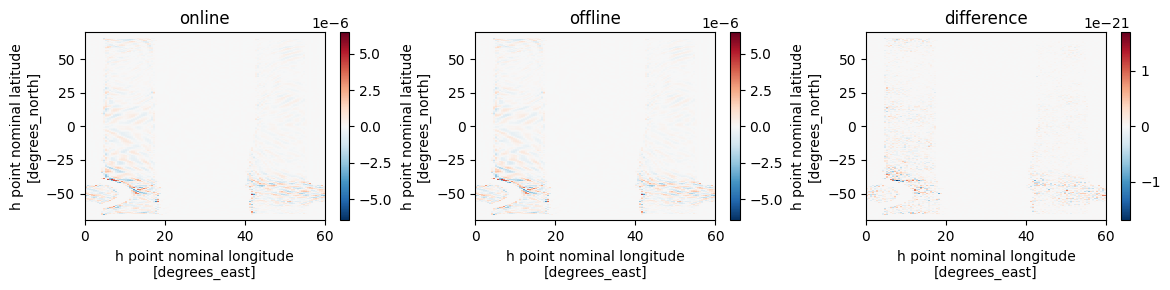

In [9]:
compare(mom.sh_xx, sh_xx, param.wet, zl=-1)

1.1468308175247153e-37


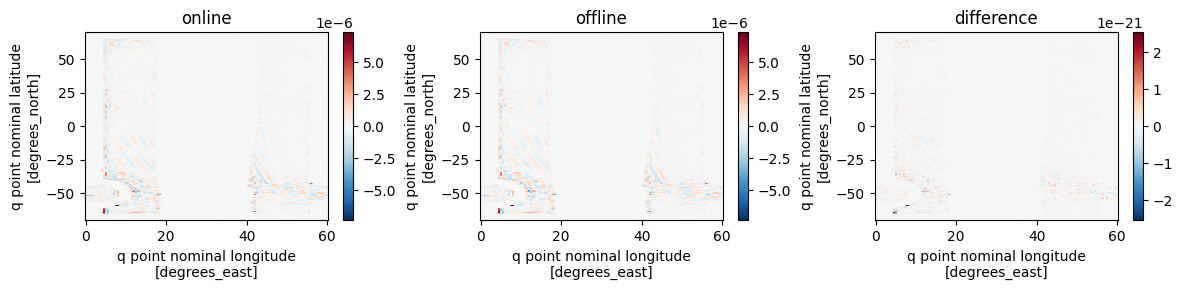

In [10]:
compare(mom.sh_xy, sh_xy, param.wet_c, zl=-1)

1.2896248487818291e-37


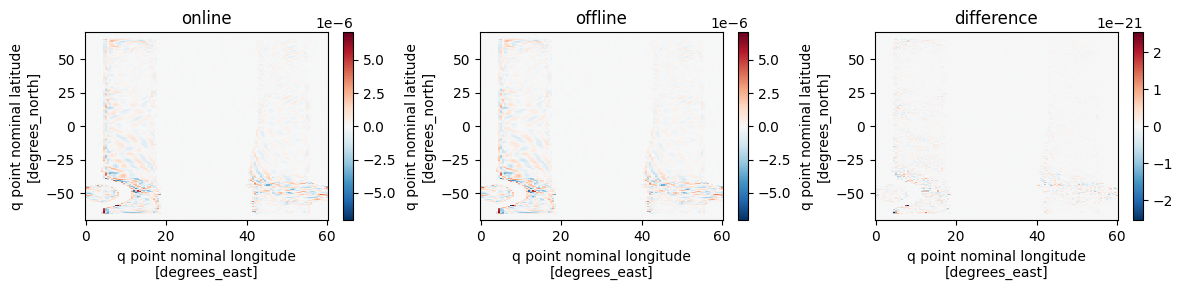

In [11]:
compare(mom.vort_xy, vort_xy, param.wet_c, zl=-1)

In [12]:
# Physical B.C.: vort_xy and sh_xy are zero on the boundary (q-points).
# Because we already applied masks,
# the interpolation to h-points is possible without additional manipulations
vort_xy_center = grid.interp(vort_xy,['X','Y'])
sh_xy_center = grid.interp(sh_xy,['X','Y'])

In [13]:
# Physical B.C.: corner points are on the boundaries. Thus, we need to place the boundary condition.
# We do it by multiplying with wet_c
sh_xx_corner = grid.interp(sh_xx,['X', 'Y']) * param.wet_c

In [14]:
vort_sh = vort_xy_center * sh_xy_center
sum_sq = 0.5 * (vort_xy_center**2 + sh_xy_center**2 + sh_xx**2)
Txx = - param.area_t * (- vort_sh + sum_sq)
Tyy = - param.area_t * (+ vort_sh + sum_sq)
Txy = - param.area_q * (vort_xy * sh_xx_corner)

In [15]:
# Physical B.C.: According to MOM6 code, the best physical B.C. is to say that thickness is zero on the boundary
# Thus, the thickness on the boundary face is not zero; Actually, it should not be zero as in Double Gyre in Southern part
# We apply it with mask
h_u = grid.interp(mom.h * param.wet, 'X')
h_v = grid.interp(mom.h * param.wet, 'Y')

In [16]:
# # Operator h_u[j]*h_u[j+1]
# from xgcm import apply_as_grid_ufunc
# def prod_1d(a):
#     return a[...,1:]*a[...,:-1]

# def prod_axis(a, axis):
#     return np.apply_along_axis(prod_1d, axis, a)

# def prod_u_Y(h_u):
#     axis = h_u.get_axis_num('yh')
#     result = mom.Txy * 0
#     result[:,1:-1,:] = prod_axis(h_u, axis)
#     return result

# def prod_v_X(h_v):
#     axis = h_v.get_axis_num('xh')
#     result = mom.Txy * 0
#     result[:,:,1:-1] = prod_axis(h_v, axis)
#     return result

In [17]:
# simplest operators for a while
def prod_u_Y(a):
    b = a.pad({'yh': (1,1)}, mode='constant', constant_values=(1e+20,1e+20)).rename({'yh': 'yq'}).drop_vars(['yq'])
    return b[:,1:,:] * b[:,:-1,:]
def prod_v_X(a):
    b = a.pad({'xh': (1,1)}, mode='wrap').rename({'xh': 'xq'}).drop_vars(['xq'])
    return b[:,:,1:] * b[:,:,:-1]    

In [18]:
# Here we assume that h_u and h_v "well defined" on the boundaries. Actually, they are defined somehow.
# One can check, that both arrays (h_u, h_v) are zero on land. The interpolation rule with multiplication leads to zero on the
# boundary (in most cases)
h2uq = 4.0 * prod_u_Y(h_u)
h2vq = 4.0 * prod_v_X(h_v)
h_neglect3 = 1e-70
hq = (2 * h2uq * h2vq) / (h_neglect3 + (h2uq+h2vq) * 2 * (grid.interp(h_u,'Y') + grid.interp(h_v,'X')))

0.0


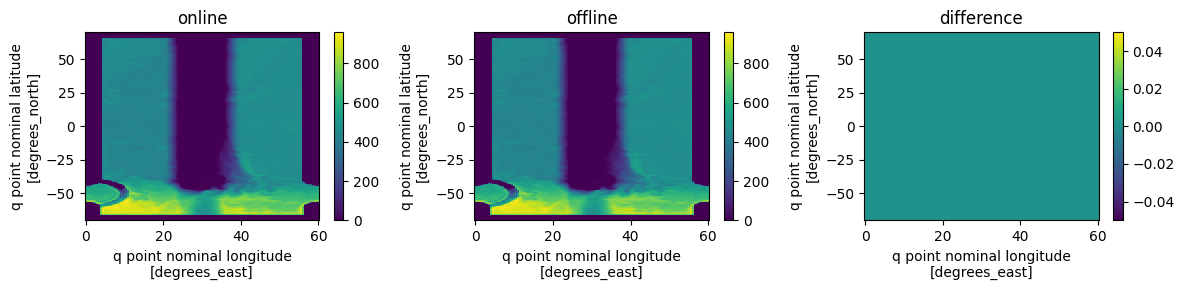

In [19]:
compare(mom.hq, hq, param.wet_c, zl=-3)

In [20]:
TTxx = Txx * mom.h
TTyy = Tyy * mom.h
TTxy = Txy * hq

3.546714216144006e-25


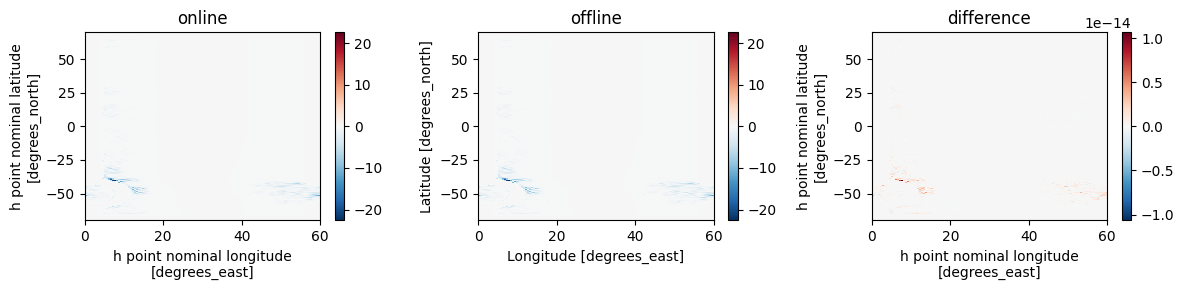

In [21]:
compare(mom.Txx, TTxx, param.wet, zl=-1)

4.835362798351786e-25


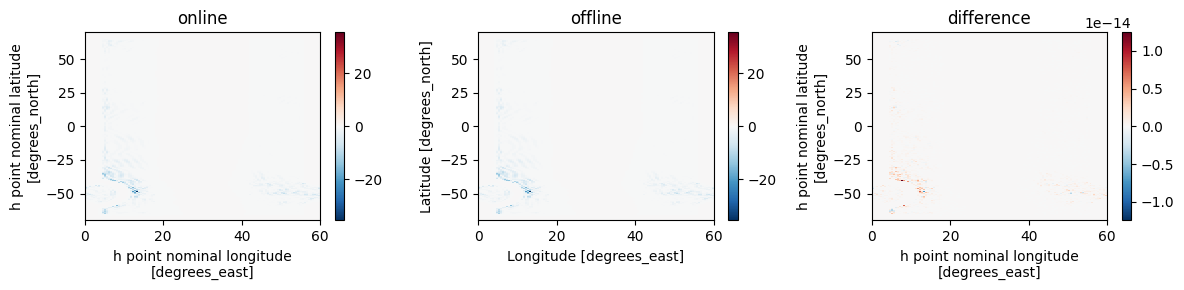

In [22]:
compare(mom.Tyy, TTyy, param.wet, zl=-1)

6.554675610533594e-26


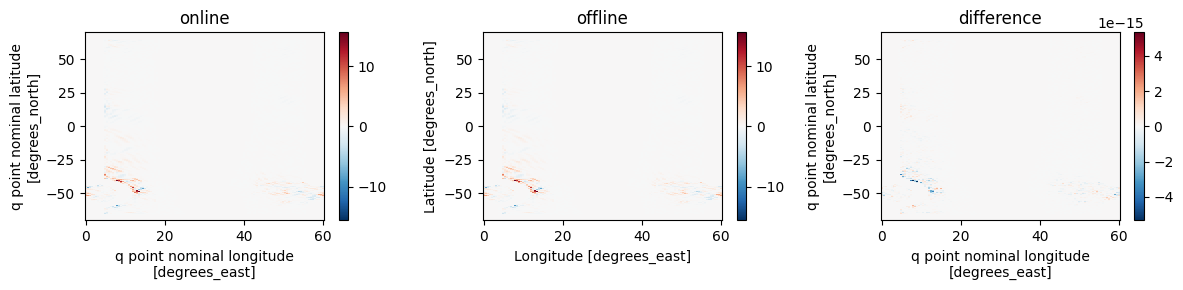

In [23]:
compare(mom.Txy, TTxy, param.wet_c, zl=-1)

In [24]:
# Physical B.C. for Txx and Tyy are not required: they contribute only to inner points do to no-flow condition on velocity
# Physical B.C. on Txy is required: it should be zero on boundary. However, we already applied this B.C. to:
# vort_xy, sh_xx_corner and hq is zero on boundary. So, B.C. are not required
ZB2020u = (grid.diff(TTxx*param.dyT**2, 'X') / param.dyCu     \
           + grid.diff(TTxy*param.dxBu**2, 'Y') / param.dxCu) \
           / (param.dxCu*param.dyCu) / (h_u+1e-70)

ZB2020v = (grid.diff(TTxy*param.dyBu**2, 'X') / param.dyCv     \
           + grid.diff(TTyy*param.dxT**2, 'Y') / param.dxCv) \
           / (param.dxCv*param.dyCv) / (h_v+1e-70)

4.172315862486437e-37


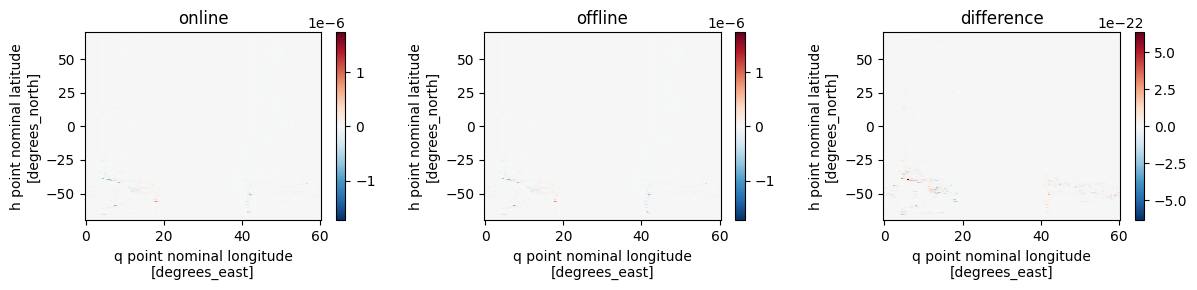

In [25]:
compare(mom.ZB2020u, ZB2020u, param.wet_u, zl=-1)

2.76467793759674e-37


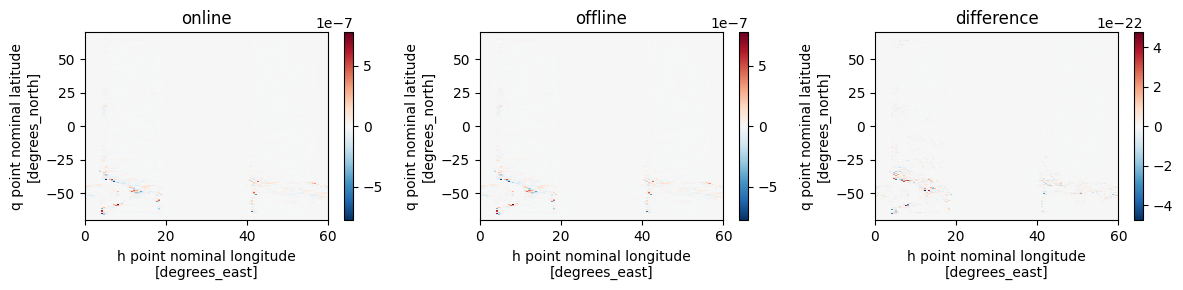

In [26]:
compare(mom.ZB2020v, ZB2020v, param.wet_v, zl=-1)

# Check a single function

In [132]:
from xgcm import Grid
def Zanna_Bolton(mom,param,Stress_iter=0,R_diss=-1):
    grid = Grid(mom, coords={
                'X': {'center': 'xh', 'outer': 'xq'},
                'Y': {'center': 'yh', 'outer': 'yq'}
                },
                periodic = 'X'
                )

    dudx = grid.diff(mom.u * param.wet_u / param.dyCu, 'X') * param.dyT / param.dxT
    dvdy = grid.diff(mom.v * param.wet_v / param.dxCv, 'Y') * param.dxT / param.dyT
    
    dudy = grid.diff(mom.u / param.dxCu, 'Y') * param.dxBu / param.dyBu * param.wet_c
    dvdx = grid.diff(mom.v / param.dyCv, 'X') * param.dyBu / param.dxBu * param.wet_c
    
    sh_xx = dudx-dvdy
    sh_xy = dvdx+dudy
    vort_xy=dvdx-dudy
    
    vort_xy_center = grid.interp(vort_xy,['X','Y'])
    sh_xy_center = grid.interp(sh_xy,['X','Y'])
    sh_xx_corner = grid.interp(sh_xx,['X', 'Y']) * param.wet_c
    
    if R_diss > 0:
        shear = np.sqrt(sh_xx**2 + grid.interp(sh_xy**2 + vort_xy**2, ['X', 'Y']))
        coriolis = np.abs(
                grid.interp(param.Coriolis, ['X', 'Y'])
                ) + 1e-30
        c_diss = 1 / (1 + shear / (coriolis * R_diss) )
    else:
        c_diss = sh_xx*0 + 1
    
    vort_sh = vort_xy_center * sh_xy_center
    sum_sq = 0.5 * (vort_xy_center**2 + sh_xy_center**2 + sh_xx**2)
    Txx = - param.area_t * (- vort_sh + sum_sq)
    Tyy = - param.area_t * (+ vort_sh + sum_sq)
    Txy = - param.area_q * (vort_xy * sh_xx_corner)
    
    h_u = grid.interp(mom.h * param.wet, 'X')
    h_v = grid.interp(mom.h * param.wet, 'Y')
    
    # simplest operators for a while
    def prod_u_Y(a):
        b = a.pad({'yh': (1,1)}, mode='constant', constant_values=(1e+20,1e+20)).rename({'yh': 'yq'}).drop_vars(['yq'])
        return b[:,1:,:] * b[:,:-1,:]
    def prod_v_X(a):
        b = a.pad({'xh': (1,1)}, mode='wrap').rename({'xh': 'xq'}).drop_vars(['xq'])
        return b[:,:,1:] * b[:,:,:-1]    
    
    h2uq = 4.0 * prod_u_Y(h_u)
    h2vq = 4.0 * prod_v_X(h_v)
    h_neglect3 = 1e-70
    hq = (2 * h2uq * h2vq) / (h_neglect3 + (h2uq+h2vq) * 2 * (grid.interp(h_u,'Y') + grid.interp(h_v,'X')))
    
    for i in range(Stress_iter):
        Txx = param.wet * filter_apply(Txx * param.wet, x_periodic=True)
        Tyy = param.wet * filter_apply(Tyy * param.wet, x_periodic=True)
        Txy = param.wet_c * filter_apply(Txy * param.wet_c,x_periodic=True)

    TTxx = Txx * mom.h * c_diss
    TTyy = Tyy * mom.h * c_diss
    TTxy = Txy * hq * grid.interp(c_diss, ['X', 'Y'])
    
    ZB2020u = (grid.diff(TTxx*param.dyT**2, 'X') / param.dyCu     \
           + grid.diff(TTxy*param.dxBu**2, 'Y') / param.dxCu) \
           / (param.dxCu*param.dyCu) / (h_u+1e-70)

    ZB2020v = (grid.diff(TTxy*param.dyBu**2, 'X') / param.dyCv     \
               + grid.diff(TTyy*param.dxT**2, 'Y') / param.dxCv) \
               / (param.dxCv*param.dyCv) / (h_v+1e-70)
    
    return ZB2020u, ZB2020v, Txx, Tyy, Txy, TTxx, TTyy, TTxy, c_diss

In [143]:
folder = '/scratch/pp2681/mom6/regression_tests/profiling-NW2'
param = xr.open_dataset(f'{folder}/ocean_geometry.nc').rename({'lonq': 'xq', 'latq': 'yq', 'lonh': 'xh', 'lath': 'yh'})
static = xr.open_dataset(f'{folder}/static.nc', decode_times=False)
param = xr.merge([param, static])
mom = xr.open_dataset(f'{folder}/mom_00030001.nc', decode_times=False).squeeze()
for key in mom.variables:
    mom[key] = mom[key].fillna(1e+20)

Error: 4.750552374047703e-38
Nans: 0


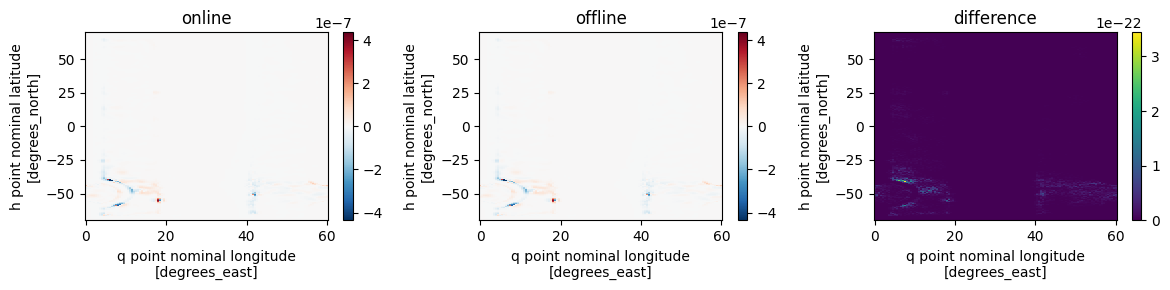

In [145]:
compare(mom.ZB2020u, Zanna_Bolton(mom,param,4, R_diss=2.0)[0], param.wet_u, zl=-1)

Error: 2.536575206637622e-38
Nans: 0


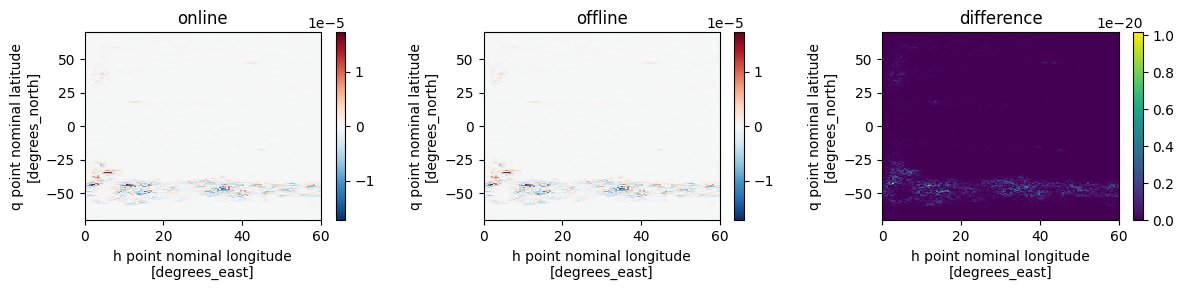

In [146]:
compare(mom.ZB2020v, Zanna_Bolton(mom,param,4, R_diss=2.0)[1], param.wet_v, zl=3)

Error: 1.9224613445573944e-28
Nans: 0


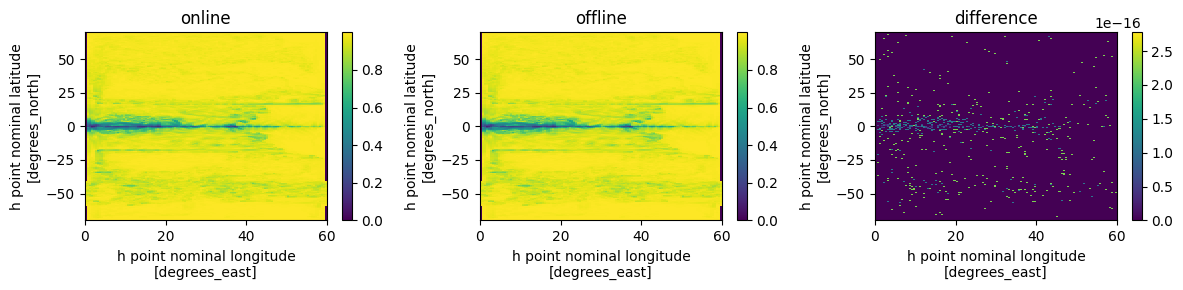

In [147]:
c_diss = Zanna_Bolton(mom,param,4,R_diss=2)[-1]
compare(mom.c_diss, c_diss, param.wet, zl=0)